# Analyzing Data Science Experience (DSX) related Stack Overflow Activity

This notebook uses the data available in posts to Stack Overflow to analyze questions for the 'DSX' service. In particular, with this notebook one can find 
* [the number of DSX questions along with their status](#question_status) (answered or unresolved)
* [correlations between DSX questions and runtime environments](#runtime)
* [correlations between DSX questions and other tags](#tags) 
* [number of unique users asking DSX questions](#demographics)

Each section includes links to related public statistics of interest.

DSX on Stack Overflow:
* [Newest DSX questions](https://stackoverflow.com/questions/tagged/data-science-experience)
* [Most popular DSX questions](https://stackoverflow.com/search?tab=votes&q=data-science-experience)

To customize this notebook:
 * [Create a new notebook from URL](https://datascience.ibm.com/docs/content/analyze-data/creating-notebooks.html) using this template: https://raw.githubusercontent.com/ibm-watson-data-lab/soanalytics/master/notebooks/SO%20analysis%20-%20dsx%20tags.ipynb
 * Add the Cloudant repository credentials for the Stack Overflow analysis database. (Credentials are available upon request)

In [1]:
# Import the required packages. (Install or update missing packages with `!pip install --user <package>`.)
import datetime
import pixiedust
import pyspark.sql.functions as func
import pyspark.sql.types as types

Pixiedust database opened successfully


In [2]:
# Configure database connectivity
# Replace the Cloudant repository credential placeholders with your credentials
# @hidden_cell
# Read-only connection credentials for the Stack Overflow repository database
# TODO: replace **...** placeholders with your Cloudant repository connection credentials
host = '**host**'
username = '**username**'
password = '**password**'
database = 'questions'

In [4]:
# Load documents from the database
# Load the documents into an Apache Spark DataFrame and describe the data structure.
view = "_design/analysis/_view/question-documents?reduce=false&include_docs=true"

spark = SparkSession\
    .builder\
    .appName("Cloudant Spark SQL Example in Python using dataframes")\
    .config("cloudant.host",host)\
    .config("cloudant.username", username)\
    .config("cloudant.password", password)\
    .config("jsonstore.rdd.partitions", 1)\
    .getOrCreate()

# Loading dataframe from Cloudant db
so_data_df = spark.read.load(format="org.apache.bahir.cloudant", database=database, view=view, schemaSampleSize="-1")
so_data_df.cache() 
#print so_data_df.count()
#so_data_df.printSchema()

DataFrame[doc: struct<_id:string,_rev:string,answered:boolean,answered_at:string,answered_by:string,answered_by_name:string,assigned:boolean,assigned_at:string,assigned_by:string,assigned_by_name:string,custom_tags:array<string>,notes:array<struct<note:string,time:string,who:string>>,otherowner:string,owner:string,question:struct<accepted_answer_id:bigint,answer_count:bigint,closed_date:bigint,closed_reason:string,creation_date:bigint,custom_tags:array<string>,is_answered:boolean,last_activity_date:bigint,last_edit_date:bigint,link:string,owner:struct<accept_rate:bigint,display_name:string,link:string,profile_image:string,reputation:bigint,user_id:bigint,user_type:string>,question_id:bigint,score:bigint,tags:array<string>,title:string,view_count:bigint>,rejected:boolean,rejected_at:string,rejected_by:string,rejected_by_name:string,rejection_reason:string,status:string,time_to_fix:string,type:string>, id: string, key: string, value: bigint]

In [5]:
# Prepare the data
key_tag = 'data-science-experience'
so_data_df = so_data_df.filter(func.array_contains("doc.question.tags",key_tag)) 

q_df = so_data_df.select(so_data_df.doc.question.question_id.alias("id"),
                         so_data_df.doc.question.title.alias("title"),
                         so_data_df.doc.question.tags.alias("tags"),                      
                         so_data_df.doc.question.is_answered.alias("answered"),
                         so_data_df.doc.question.answer_count.alias("answer_count"),  
                         so_data_df.doc.question.link.alias("link"),
                         so_data_df.doc.question.score.alias("score"),
                         so_data_df.doc.question.view_count.alias("views"),
                         so_data_df.doc.question.creation_date.alias("created"),
                         so_data_df.doc.question.owner.user_id.alias("originator"),
                         func.lit(1).alias("count")
                        )

def toUTCDatetime(created):
    """ 
    input: POSIX timestamp
    output: instance of datetime.datetime represeting the input
    """ 
    if created is not None:
        return datetime.datetime.utcfromtimestamp(created)
    return None
toUTCDatetimeUDF = func.udf(lambda c: toUTCDatetime(c), types.TimestampType())
q_df = q_df.withColumn("created", toUTCDatetimeUDF(q_df.created))

def getFormattedDateString(date_val, format_string):
    """ 
    input: datetime.datetime object
    input: date format string
    output: formatted date string
    """
    if date_val is not None:
        return date_val.strftime(format_string)
    return None
    
getFormattedDateStringUDF = func.udf(lambda d,f: getFormattedDateString(d,f), types.StringType())
q_df = q_df.withColumn("created_year", getFormattedDateStringUDF(q_df.created, func.lit("%Y")))
q_df = q_df.withColumn("created_month", getFormattedDateStringUDF(q_df.created, func.lit("%Y-%m")))
q_df = q_df.withColumn("created_day", getFormattedDateStringUDF(q_df.created, func.lit("%Y-%m-%d")))


def deriveStatus(col1, col2):
    if col1 == True:
        return "Answered"
    elif col2 == 0:
        return "Not answered"
    else:
        return "No accepted answer"
deriveStatusUDF = func.udf(lambda c1,c2: deriveStatus(c1,c2), types.StringType())
q_df = q_df.withColumn("status", deriveStatusUDF(q_df.answered, q_df.answer_count))

# debug only
#q_df.printSchema()
#q_df.head(10)

<a id="question_status"></a> 
***
## Question status statistics

 Stack Overflow questions are in one of three states:
  * **Answered**:  The person who asked a question has selected one answer as the "correct" one: 
     <img src="https://raw.githubusercontent.com/ibm-watson-data-lab/soanalytics/master/notebooks/images/accepted_answer.png"></img>
  * **No accepted answer**: The person who asked a question did not select one answer as the "correct" one: 
    > Note: Just because a question doesn't have an accepted answer doesn't mean that no valid answer was provided. [Learn more ...](https://stackoverflow.com/help/accepted-answer)
  * **Not answered**: Nobody has formally answered the question.


### Stack Overflow links
 * DSX questions for which [an answer was accepted](https://stackoverflow.com/search?q=[data-science-experience]+hasaccepted%3Ayes). *No action is required.*
 * DSX questions for which [no answer was provided](https://stackoverflow.com/search?q=%5Bdata-science-experience%5D+hasaccepted%3Ano+answers%3A0). *Action may be required.*
 * DSX questions for which [no answer was accepted](https://stackoverflow.com/unanswered/tagged/data-science-experience). *Action may be required.*


### Statistics

Totals: Run the next cell and ...
* Choose `Options` > `Keys` > `created_day` to display daily totals
* Choose `Options` > `Keys` > `created_month` to display monthly totals (default)
* Choose `Options` > `Keys` > `created_year` to display yearly totals



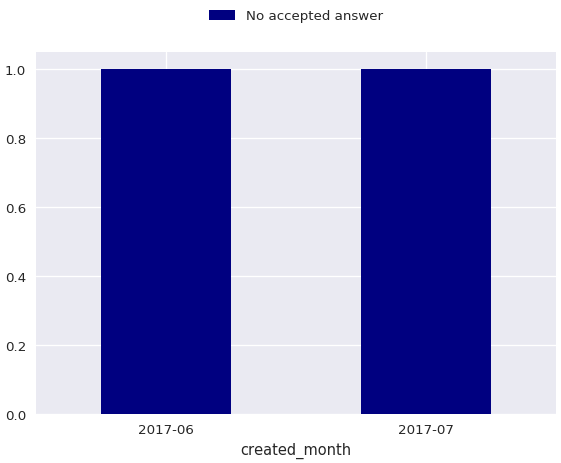

In [6]:
display(q_df)

***
<a id="runtime"></a> 

## Data services associations

Stack overflow users often tag DSX questions to make it easier for others to find and answer questions. [Learn more ...](https://stackoverflow.com/tags/)

 <img src="https://raw.githubusercontent.com/ibm-watson-data-lab/soanalytics/master/notebooks/images/tags.png"></img>
 
 
Run the next cell to determine how many questions were tagged with terms that are commonly associated with runtime environments (in the broader sense).
Use these statistics to identify runtime environments that users struggle with the most.


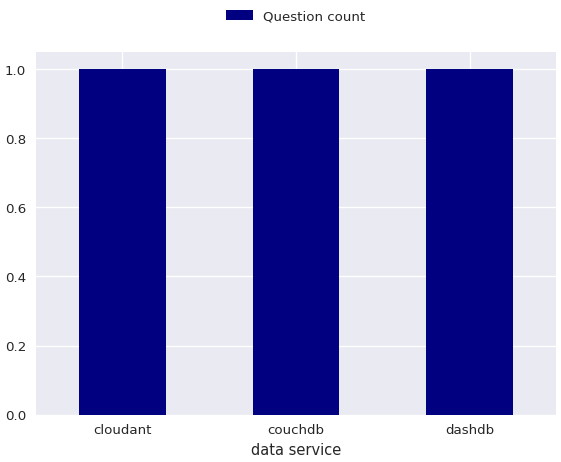

In [12]:
# count questions that contain a tag that is associated with a data service
# the following curated list was obtained from https://meta.stackoverflow.com/tags; customize as needed
env = ["cloudant", "dashdb", "couchdb"]

# ---------------
# prepare data
# ---------------
env_df = q_df.select(q_df.id, q_df.tags)
env_df = env_df.select(env_df.id, func.explode(env_df.tags).alias("tag"))
env_df = env_df.filter(func.col("tag").isin(env)).groupBy(["tag"]).agg(func.count(func.lit(1)).alias("Question count")).orderBy("Question count", ascending = False).withColumnRenamed("tag","data service")

display(env_df)

<a id="tags"></a> 
***
## General tag associations

Run the next cell to identify tags that were commonly associated with DSX. [Learn more...](https://stackoverflow.com/tags/)
 > Note: You can black list tags that should be ignored. Follow the instructions in the cell.


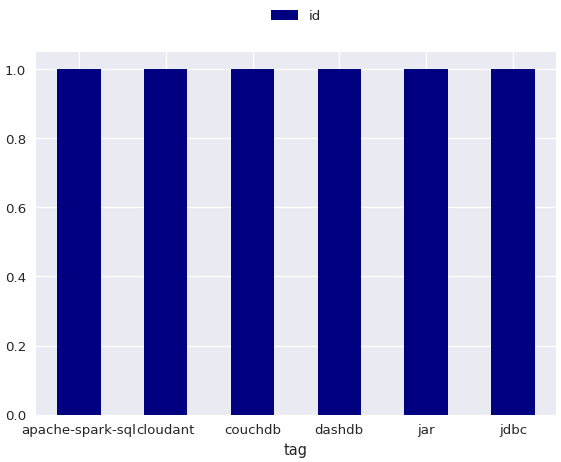

In [8]:
# TODO (Optional)
#  - Run this cell and inspect the output. Add or remove tags as necessary from the default list in the next line
ignore_list = ['ibm-bluemix','ibm']

tags_df = q_df.select(q_df.id, q_df.status, q_df.answered, q_df.answer_count, q_df.tags, q_df.created_year, q_df.created_month,q_df.created_day)
tags_df = tags_df.select(tags_df.id, func.explode(tags_df.tags).alias("tag"), tags_df.status, tags_df.answered, tags_df.answer_count, tags_df.created_year, tags_df.created_month, tags_df.created_day).filter("tag != '{}'".format(key_tag)).dropDuplicates(["id","tag"])

# apply optional filter to remove tags that are in the ignore list
if len(ignore_list) > 0:
    def applyFilter(col):
        return col not in ignore_list
    applyFilterUDF = func.udf(lambda c: applyFilter(c), types.BooleanType())
    tags_df = tags_df.filter(applyFilterUDF(tags_df.tag)) 

display(tags_df)

### Question status by tag

Run the next cell to determine whether there's a correlation between question status and tags.


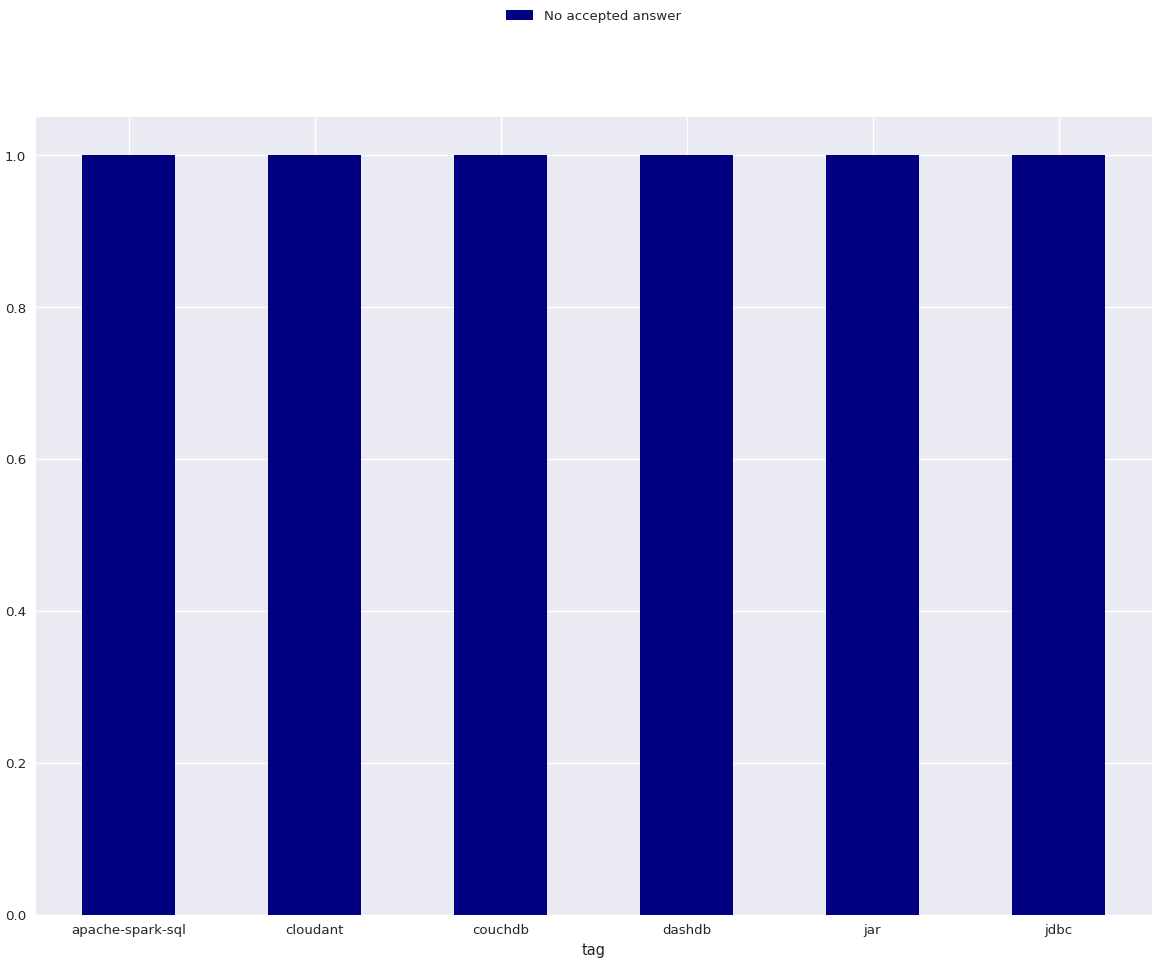

In [9]:
# answer status by tag, e.g. "tag" answered: 25 not answered: 12
display(tags_df.dropDuplicates(["id","tag"]))

***

<a id="demographics"></a> 

## Demographics

Stack Overflow links:
* [Top DSX askers and answerers](https://stackoverflow.com/tags/DSX/topusers) (last 30 days and all time)

### Who is asking questions about DSX

How many different people ask questions about DSX per day/month/year?



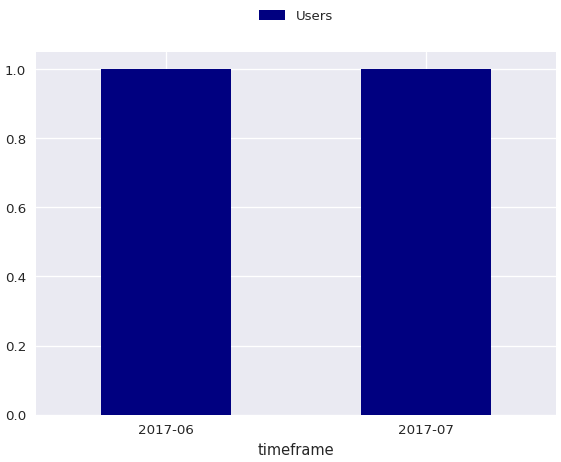

In [10]:
# TODO: select the desired timeframe
# unique users per day
#timeframe = 'day'
# unique users per month (default)
timeframe = 'month'
# unique users per year
#timeframe = 'year'

column = 'created_{}'.format(timeframe)

# display(q_df.withColumnRenamed(column, "timeframe").dropDuplicates(["timeframe", "originator"]).groupBy("timeframe").count())
display(q_df.withColumnRenamed(column, "timeframe").dropDuplicates(["timeframe", "originator"]).groupBy(["timeframe"]).agg(func.count(func.lit(1)).alias("Users")).orderBy("Users", ascending = False))